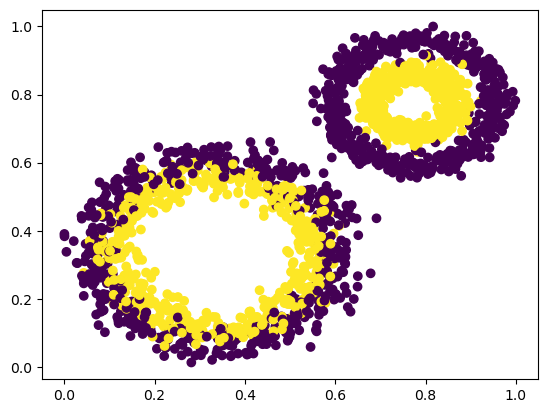

In [2]:
import numpy as np 
from sklearn.datasets import make_moons, make_circles
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

data = make_circles(n_samples=1000, noise=0.1, random_state=0)
data2 = make_circles(n_samples=1000, noise=0.1, random_state=1, factor=0.5)

X = np.concatenate([data[0], data2[0] / 1.5 + 1.6]) 
y = np.concatenate([data[1], data2[1]])

# Normalize the data to 0-1
X = (X - X.min()) / (X.max() - X.min())

plt.scatter(X[:,0], X[:,1], c=y)
plt.savefig('data.png')

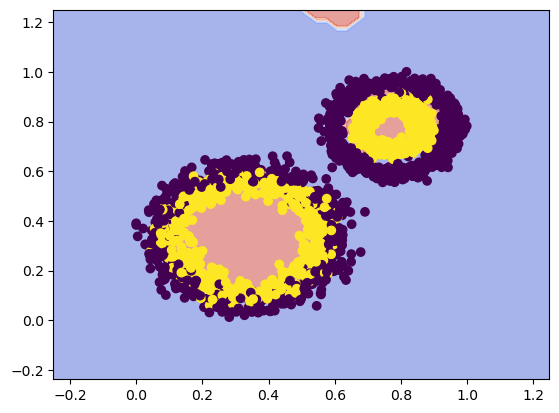

In [3]:
modelMLP = MLPClassifier(hidden_layer_sizes=(50,20, 5), max_iter=1000, learning_rate_init=0.01, solver='adam', random_state=0, activation='tanh')

modelMLP.fit(X,y)

def plot_decision_boundary(modelMLP, X, y):
    x_span = np.linspace(min(X[:,0]) - 0.25, max(X[:,0]) + 0.25)
    y_span = np.linspace(min(X[:,1]) - 0.25, max(X[:,1]) + 0.25)
    xx, yy = np.meshgrid(x_span, y_span)
    xx_, yy_ = xx.ravel(), yy.ravel()
    grid = np.c_[xx_,yy_]
    pred_func = modelMLP.predict(grid)
    z = pred_func.reshape(xx.shape)
    plt.contourf(xx,yy,z, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.scatter(X[:,0], X[:,1], c=y)
    
plot_decision_boundary(modelMLP, X, y)

In [4]:
proba = modelMLP.predict_proba([[0,0.6]])[0]
print(f'Probabilities: "0": {proba[0]:.3f}, "1": {proba[1]:.3f}')

Probabilities: "0": 0.990, "1": 0.010


In [5]:
x = np.array([0,0])
eps = 0.5
y_class = modelMLP.predict([x])[0]
lr = 0.0001
max_iter = 1000
alpha = 1e4
beta = 1e1

cf_class = 1 - y_class

history = []
grad_history = []
proximity_history = []
proba_history = []


current_x = x.copy()

for i in range(max_iter):
    history.append(current_x.copy())
    
    proximity_left = np.mean((x - (current_x + eps)) ** 2)**0.5
    left = modelMLP.predict_proba([current_x + eps])[:,  cf_class]
    
    proximity_current = np.mean((x - current_x) ** 2)**0.5
    current = modelMLP.predict_proba([current_x])[:, cf_class]
    
    grad = ((alpha * left - beta * proximity_left) \
            - (alpha * current - beta * proximity_current)) / eps
    
    grad_history.append(np.mean(grad))
    proximity_history.append(proximity_current)
    proba_history.append(current)
    
    
    if current > 0.5:
        print('Done')
        break
    
    current_x = current_x + current * lr * grad
    
print('---------------')
print(f'Iterations: {i+1}')
print(f'Current x: {current_x}')
print(f'Current class: {modelMLP.predict_proba([current_x])}')    

---------------
Iterations: 1000
Current x: [0.06472653 0.06472653]
Current class: [[0.9418082 0.0581918]]


Text(0.5, 1.0, 'Class probability')

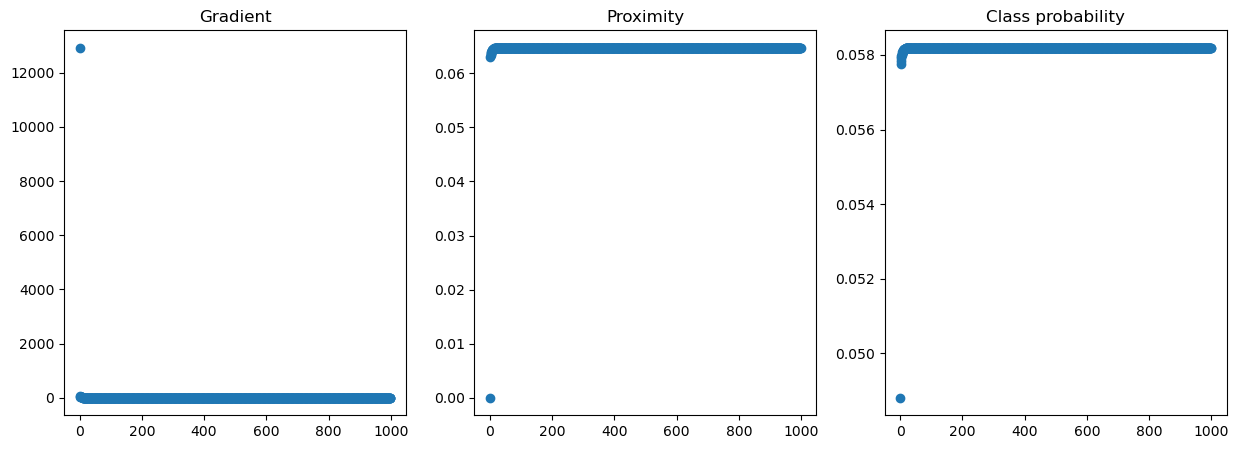

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))

ax = ax.flatten()

ax[0].scatter(np.arange(len(grad_history)), np.array(grad_history))
ax[0].set_title('Gradient')

ax[1].scatter(np.arange(len(proximity_history)), np.array(proximity_history))
ax[1].set_title('Proximity')

ax[2].scatter(np.arange(len(proba_history)), np.array(proba_history))
ax[2].set_title('Class probability')

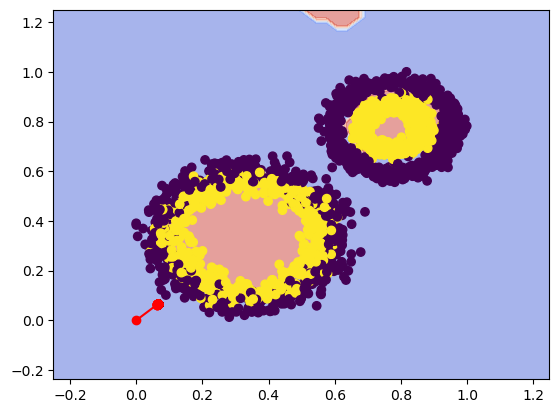

In [7]:
plot_decision_boundary(modelMLP, X, y)
# plot history
history = np.array(history)
plt.plot(history[:,0], history[:,1], 'ro-')

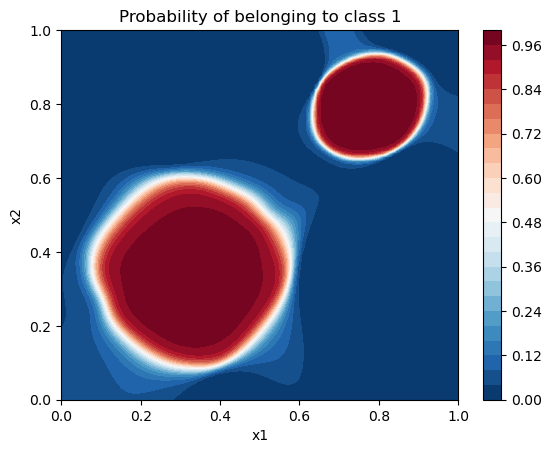

In [8]:
grid = np.linspace(np.min(X), np.max(X), 100)
xx, yy = np.meshgrid(grid, grid)

grid = np.c_[xx.ravel(), yy.ravel()]

# Predict probabilities for each point in the grid
probs = modelMLP.predict_proba(grid)[:, 1].reshape(xx.shape)

# Plot the probabilities
plt.contourf(xx, yy, probs, 25, cmap="RdBu_r", vmin=0, vmax=1)
plt.title("Probability of belonging to class 1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.savefig('not_calibratedNN.png')
plt.show()

Running trials: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


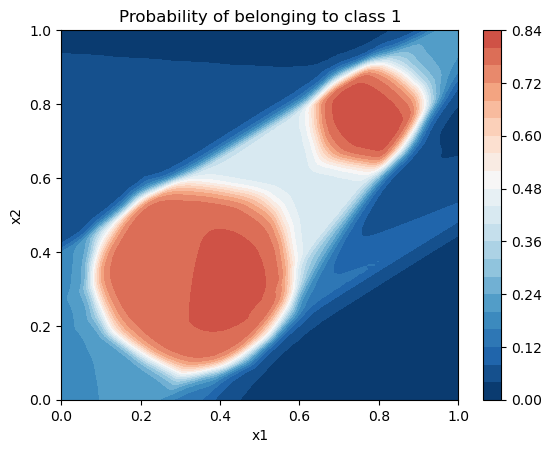

In [9]:
from tqdm import tqdm
hyperparams = {
    'hidden_layer_sizes': [(8,8), (16,8), (16, 8, 4), (32, 16), (64, 16)],
    'max_iter': [1000],
    'learning_rate_init': [0.01],
    'solver': ['adam'],
    'random_state': [0, 1, 2, 3],
    'activation': ['relu'], 
    'learning_rate': ['constant', 'adaptive'],
    # 'early_stopping': [True],
}

TRIALS = 20
results = np.zeros(shape=(xx.shape[0], xx.shape[1], TRIALS))

for t in tqdm(range(TRIALS), total=TRIALS, desc='Running trials'):
    _model = MLPClassifier(**{k: v[np.random.randint(0,len(v))] for k, v in hyperparams.items()})
    _model.fit(X,y)
    results[:,:,t] = _model.predict_proba(grid)[:, 1].reshape(xx.shape)
    
probs = np.mean(results, axis=2)

plt.contourf(xx, yy, probs, 25, cmap="RdBu_r", vmin=0, vmax=1)
plt.title("Probability of belonging to class 1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.savefig('calibratedNN.png')
plt.show()


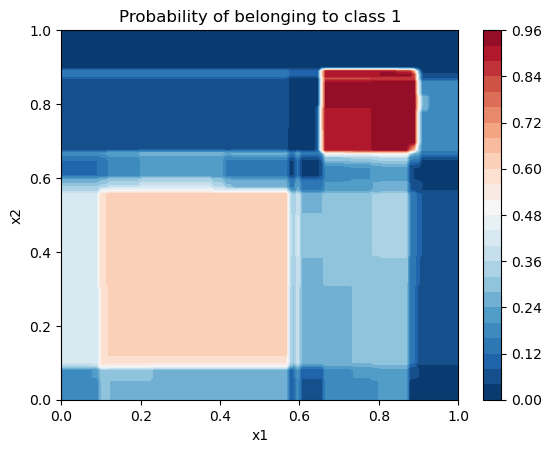

In [10]:
# Do the same for random forest

from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0)
model_rf.fit(X,y)
probs = model_rf.predict_proba(grid)[:, 1].reshape(xx.shape)

plt.contourf(xx, yy, probs, 25, cmap="RdBu_r", vmin=0, vmax=1)
plt.title("Probability of belonging to class 1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.savefig('not_calibratedRF.png')
plt.show()

Running trials: 100%|██████████| 15/15 [00:00<00:00, 24.06it/s]


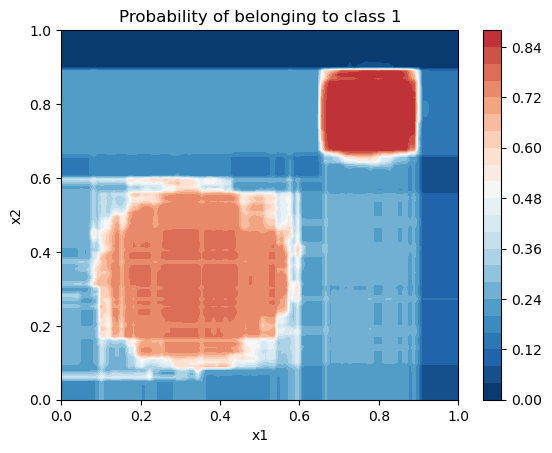

In [11]:


hyperparams = {
    'n_estimators': [2, 4, 6, 10, 20, 30],
    'max_depth': [None, 2, 4, 6, 10, 15],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'random_state': [0],
    'n_jobs': [4],
}

TRIALS = 15
results = np.zeros(shape=(xx.shape[0], xx.shape[1], TRIALS))

for t in tqdm(range(TRIALS), total=TRIALS, desc='Running trials'):
    _model = RandomForestClassifier(**{k: v[np.random.randint(0,len(v))] for k, v in hyperparams.items()})
    _model.fit(X,y)
    results[:,:,t] = _model.predict_proba(grid)[:, 1].reshape(xx.shape)
    
probs = np.mean(results, axis=2)

plt.contourf(xx, yy, probs, 25, cmap="RdBu_r", vmin=0, vmax=1)
plt.title("Probability of belonging to class 1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.savefig('calibratedRF.png')
plt.show()

## RobX

In [15]:
# Counterfactual stability metric

def counterfactual_stability(x: np.array, pred_func: object, variance: np.array, cf_class: int, N: int = 100) -> float:
    ''' 
    Calculate the Counterfactual stability metric for a given point x.
    
    Parameters:
        - x: the point for which the metric is calculated (np.array 1D)
        - pred_func: a function that returns the probability of belonging to class 1
        - variance: the variance of the data points in the training set (np.array 1D)
        - cf_class: the class for which the counterfactual is calculated
        - N: the number of samples to be generated (int)
    '''
    
    cov_mat = np.eye(len(x)) * variance
    X_p = np.random.multivariate_normal(x, cov_mat, size=(N,), check_valid='raise')
    
    
    X_pred = pred_func(X_p) if cf_class == 1 else 1 - pred_func(X_p) 
    
    c_mean = np.mean(X_pred)
    c_variance = np.mean((X_pred - c_mean) ** 2)  ** 0.5
    c_stability = c_mean - c_variance
    
    return c_stability


def MLP_predict_class_1_proba(x):
    return modelMLP.predict_proba(x)[:, 1]

def RF_predict_class_1_proba(x):
    return model_rf.predict_proba(x)[:, 1]

var = np.var(X, axis=0)
example = np.array([0,0])
counterfactual_stability(example, MLP_predict_class_1_proba, var, cf_class=0, N=100)

0.5914147042452906

Calculating counterfactual stability (experiment 1/3):   0%|          | 0/100 [00:00<?, ?it/s]

Calculating counterfactual stability (experiment 1/3): 100%|██████████| 100/100 [00:07<00:00, 12.57it/s]


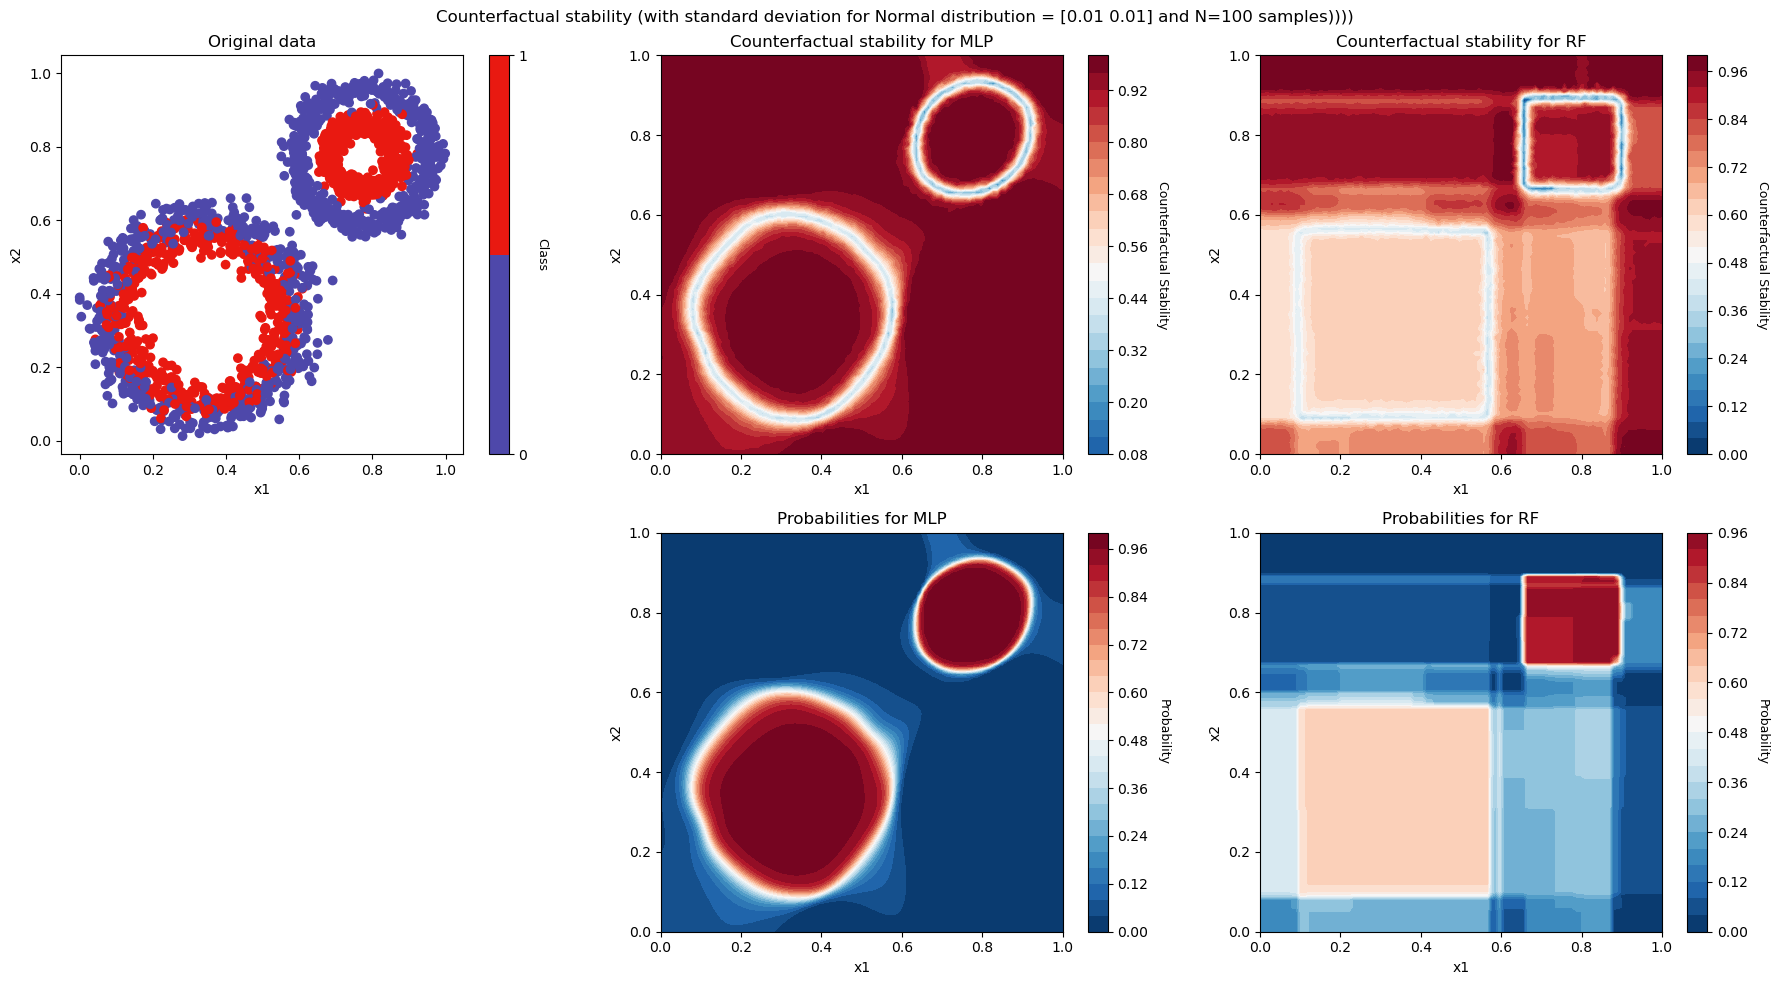

Calculating counterfactual stability (experiment 2/3): 100%|██████████| 100/100 [00:07<00:00, 13.17it/s]


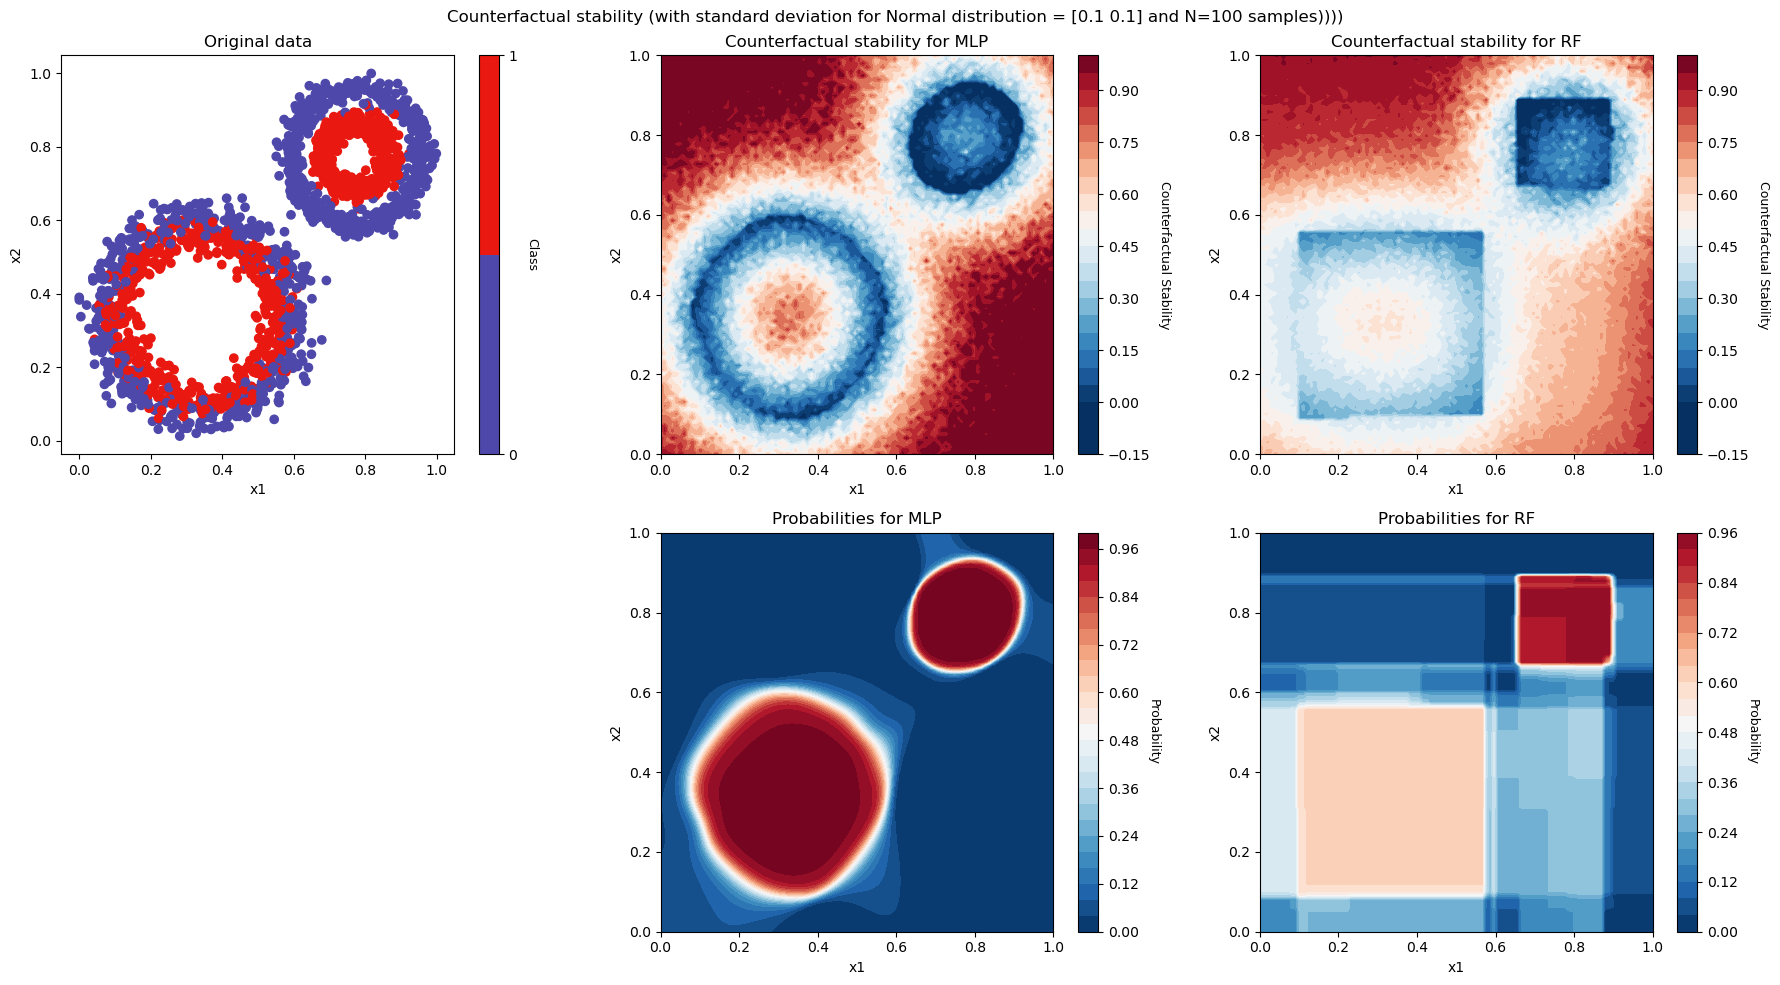

Calculating counterfactual stability (experiment 3/3): 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


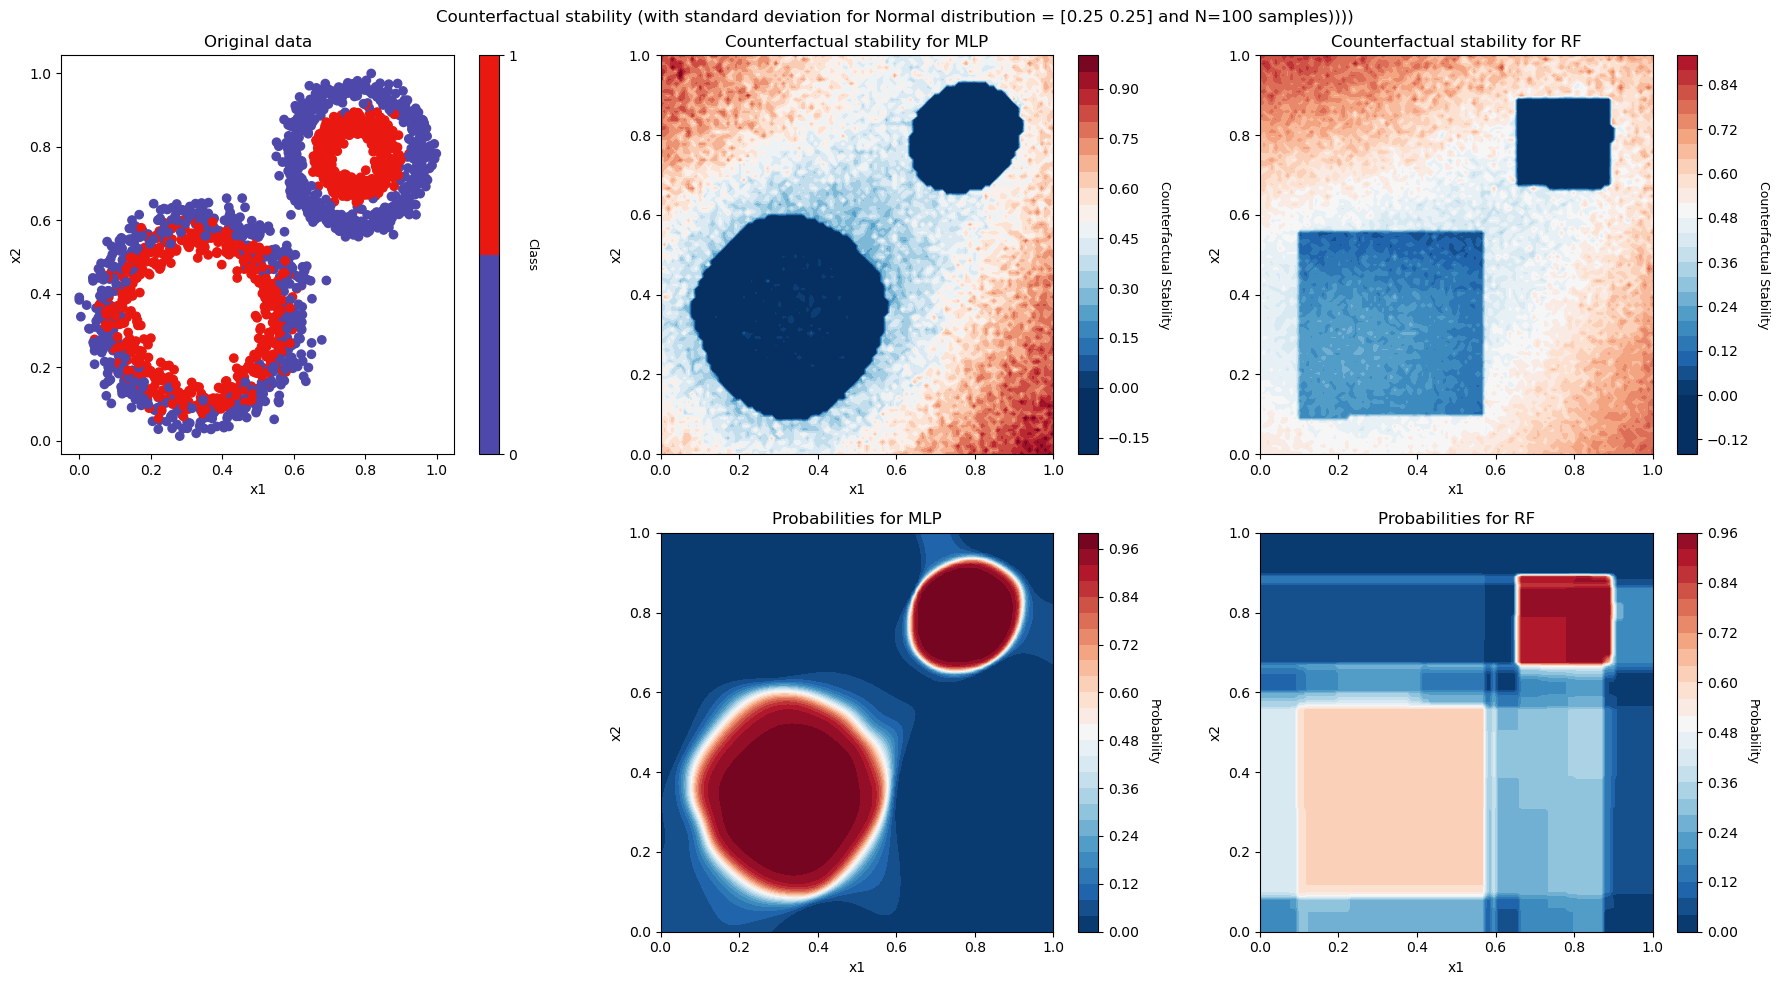

In [16]:
from matplotlib.colors import ListedColormap

# Calculate the counterfactual stability for all points in the grid
resultsMLP = np.zeros(shape=(xx.shape[0], xx.shape[1]))
probabilitiesMLP = np.zeros(shape=(xx.shape[0], xx.shape[1]))
resultsRF = np.zeros(shape=(xx.shape[0], xx.shape[1]))
probabilitiesRF = np.zeros(shape=(xx.shape[0], xx.shape[1]))


probabilitiesMLP = modelMLP.predict_proba(grid)[:, 1].reshape(xx.shape)
probabilitiesRF = model_rf.predict_proba(grid)[:, 1].reshape(xx.shape)

# HYPERPARAMETERS
STDDEVS = [np.array([0.01,0.01]), np.array([0.1,0.1]), np.array([0.25,0.25])]
for e, STDDEV in enumerate(STDDEVS):
    N = 100
    VAR = STDDEV ** 2
    
    
    for i in tqdm(range(xx.shape[0]), desc=f'Calculating counterfactual stability (experiment {e+1}/{len(STDDEVS)})'):
        for j in range(xx.shape[1]):
            c = 1 if probabilitiesMLP[i,j] > 0.5 else 0
            resultsMLP[i,j] = counterfactual_stability(np.array([xx[i,j], yy[i,j]]), MLP_predict_class_1_proba, VAR, N=N, cf_class=c)
            c = 1 if probabilitiesRF[i,j] > 0.5 else 0
            resultsRF[i,j] = counterfactual_stability(np.array([xx[i,j], yy[i,j]]), RF_predict_class_1_proba, VAR, N=N, cf_class=c)

    fig, ax  = plt.subplots(figsize=(18,10), ncols=3, nrows=2)
    
    ax = ax.flatten()


    # Plot original data with discrete colorbar
    cmap = ListedColormap(['#4e48aa', '#e91911'])
    classes = [0, 0.5, 1]  # Set boundaries for two classes

    scatter = ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, norm=plt.Normalize(min(classes), max(classes)))
    ax[0].set_title('Original data')
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    cbar0 = plt.colorbar(scatter, ax=ax[0], boundaries=classes, ticks=[0, 1])
    cbar0.set_label('Class', rotation=270, fontsize=9, labelpad=15)


    # Plot counterfactual stability for MLP
    contour = ax[1].contourf(xx, yy, resultsMLP, 25, cmap="RdBu_r", vmin=0, vmax=1)
    ax[1].set_title('Counterfactual stability for MLP')
    ax[1].set_xlabel('x1')
    ax[1].set_ylabel('x2')

    cbar1 = plt.colorbar(contour, ax=ax[1])
    cbar1.set_label('Counterfactual Stability', rotation=270, fontsize=9, labelpad=15)


    # Plot counterfactual stability for RF
    contour = ax[2].contourf(xx, yy, resultsRF, 25, cmap="RdBu_r", vmin=0, vmax=1)
    ax[2].set_title('Counterfactual stability for RF')
    ax[2].set_xlabel('x1')
    ax[2].set_ylabel('x2')

    cbar2 = plt.colorbar(contour, ax=ax[2])
    cbar2.set_label('Counterfactual Stability', rotation=270, fontsize=9, labelpad=15)
    
    # Remove ax[3]
    ax[3].remove()
    
    
    # Plot probabilities for MLP
    contour = ax[4].contourf(xx, yy, probabilitiesMLP, 25, cmap="RdBu_r", vmin=0, vmax=1)
    ax[4].set_title('Probabilities for MLP')
    ax[4].set_xlabel('x1')
    ax[4].set_ylabel('x2')
    
    cbar4 = plt.colorbar(contour, ax=ax[4])
    cbar4.set_label('Probability', rotation=270, fontsize=9, labelpad=15)
    
    # Plot probabilities for RF
    contour = ax[5].contourf(xx, yy, probabilitiesRF, 25, cmap="RdBu_r", vmin=0, vmax=1)
    ax[5].set_title('Probabilities for RF')
    ax[5].set_xlabel('x1')
    ax[5].set_ylabel('x2')
    
    cbar5 = plt.colorbar(contour, ax=ax[5])
    cbar5.set_label('Probability', rotation=270, fontsize=9, labelpad=15)


    plt.suptitle(f'Counterfactual stability (with standard deviation for Normal distribution = {STDDEV} and N={N} samples))))')
    plt.tight_layout(w_pad=2)
    plt.savefig(f'counterfactual_stability_{STDDEV}.png')
    plt.show()
    